# コード4-1：時間遅れをもつ微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

時間遅れをもつ微分方程式の数値計算の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み

In [36]:
## 必要があればインストール
# !pip3 install matplotlib numpy scipy statsmodels ddeint

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from ddeint import ddeint
from scipy.integrate import odeint

## 時間遅れをもつ微分方程式

式(4.6)

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d I(t)}{dt} = \beta \int^{t}_{0}{f(a) T(t - a) V(t - a)} da - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

$f(a)$は式(4.3)

$$
f(a) = \mu_E(a) e^{- \int^{a}_{0}{\mu_E(s)}ds}
$$

### 固定遅れをもつ常微分方程式

$f(a)$がデルタ関数の場合、固定遅れを$\tau$とすると、

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d I(t)}{dt} = \beta T(t - \tau) V(t - \tau) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

である。

ここでは`ddeint`ライブラリを用いて計算する。  
https://pypi.org/project/ddeint/

In [38]:
## 計算する時刻の設定
Tmin = 0.0
Tmax = 30.0
step_size = 0.01

## beta, delta, p, c, tau, T(0), I(0), V(0)
pars1 = np.array([1.0*np.power(10.0, -10.0), #beta
                  0.5,                        #delta
                  3.0*np.power(10.0, 4.0),    #p
                  2.0,                        #c
                  2.0,                        #tau
                  6.46*np.power(10.0, 6.0),   #T(0)
                  np.power(10.0, -1.0),       #I(0)
                  5.0*np.power(10.0, 4.0)])   #V(0)

In [39]:
def dde_derives(var, t, beta, delta, p, c, tau):
    
    TC, IC, VL = var(t)
    TCd, ICd, VLd = var(t - tau)
    
    dTdt = - beta * TC * VL
    dIdt = beta * TCd * VLd - delta * IC
    dVdt = p * IC - c * VL
    return [dTdt, dIdt, dVdt]


def DDEs(parms):
    beta = parms[0]
    delta = parms[1]
    p = parms[2]
    c = parms[3]
    tau = parms[4]

    ## 計算のタイムステップ
    t_list = np.arange(Tmin, Tmax + step_size, step_size)
    ## t < tauのときのT, I, Vの値 <- 引数tに対してnumpyのarrayを返す関数
    values_before_tau = lambda t: np.array([parms[5], parms[6], parms[7]])
    ## 微分方程式の計算
    var_list = ddeint(dde_derives, values_before_tau, t_list, fargs=(beta, delta, p, c, tau))

    return np.vstack([t_list, var_list.T])

In [40]:
out1 = DDEs(pars1)

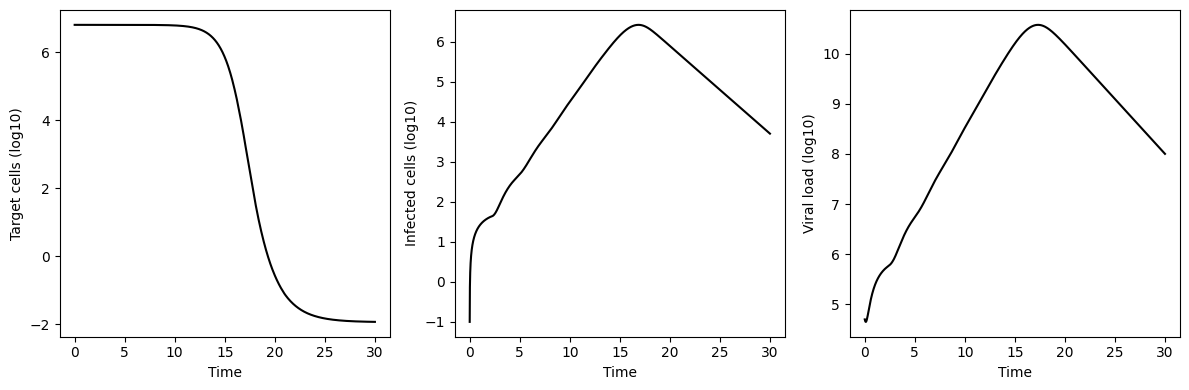

In [41]:
## プロットの準備
fig = plt.figure(figsize=(12,4))

## V(t)のプロット
ax1 = fig.add_subplot(1, 3, 1) ## 1行2列のプロットの１番目
ax1.plot(out1[0], np.log10(out1[1]), color = "black") ## pars1でのT(t)の数値解のプロット
ax1.set_xlabel("Time") ## x軸のラベル
ax1.set_ylabel("Target cells (log10)") ## y軸のラベル

## I(t)のプロット
ax2 = fig.add_subplot(1, 3, 2) ## 1行2列のプロットの１番目
ax2.plot(out1[0], np.log10(out1[2]), color = "black") ## pars1でのI(t)の数値解のプロット
ax2.set_xlabel("Time") ## x軸のラベル
ax2.set_ylabel("Infected cells (log10)") ## y軸のラベル

## V(t)のプロット
ax3 = fig.add_subplot(1, 3, 3) ## 1行2列のプロットの2番目
ax3.plot(out1[0], np.log10(out1[3]), color = "black") ## pars1でのV(t)の数値解のプロット
ax3.set_xlabel("Time") ## x軸のラベル
ax3.set_ylabel("Viral load (log10)") ## y軸のラベル

fig.tight_layout()
fig.show()

### 暗黒期細胞コンパートメントを含む式

$f(a)$が指数関数の場合、式(4.2)

$$
\frac{d T(t)}{dt} = g T(t) \left( 1 - \frac{T(t)}{T_{\text{max}}} \right) - \beta T(t) V(t) \\
\frac{d E(t)}{dt} = \beta T(t) V(t) - k E(t) \\
\frac{d I(t)}{dt} = k E(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

において、細胞増殖項$g T(t) \left( 1 - \frac{T(t)}{T_{\text{max}}} \right)$がない場合の式

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d E(t)}{dt} = \beta T(t) V(t) - k E(t) \\
\frac{d I(t)}{dt} = k E(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

である。

In [42]:
## 計算する時刻の設定
Tmin = 0.0
Tmax = 30.0
step_size = 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars2 = np.array([1.0*np.power(10.0, -10.0), #beta
                  0.5,                        #delta
                  3.0*np.power(10.0, 4.0),    #p
                  2.0,                        #c
                  1/2.0,                      #k
                  6.46*np.power(10.0, 6.0),   #T(0)
                  np.power(10.0, -1.0),       #E(0)
                  np.power(10.0, -1.0),       #I(0)
                  5.0*np.power(10.0, 4.0)])   #V(0)

In [43]:
def ode_derives(var, t, beta, delta, p, c, k):
    
    TC, EC, IC, VL = var
    
    dTdt = - beta * TC * VL
    dEdt = beta * TC * VL - k * EC
    dIdt = k * EC - delta * IC
    dVdt = p * IC - c * VL
    return [dTdt, dEdt, dIdt, dVdt]


def ODEs(parms):
    beta = parms[0]
    delta = parms[1]
    p = parms[2]
    c = parms[3]
    k = parms[4]

    ## 計算のタイムステップ
    t_list = np.arange(Tmin, Tmax + step_size, step_size)
    ## 初期値 T(0), E(0), I(0), V(0)
    var_init = [parms[5], parms[6], parms[7], parms[8]]
    ## 微分方程式の計算
    var_list = odeint(ode_derives, var_init, t_list, args = (beta, delta, p, c, k))

    return np.vstack([t_list, var_list.T])

In [44]:
out2 = ODEs(pars2)

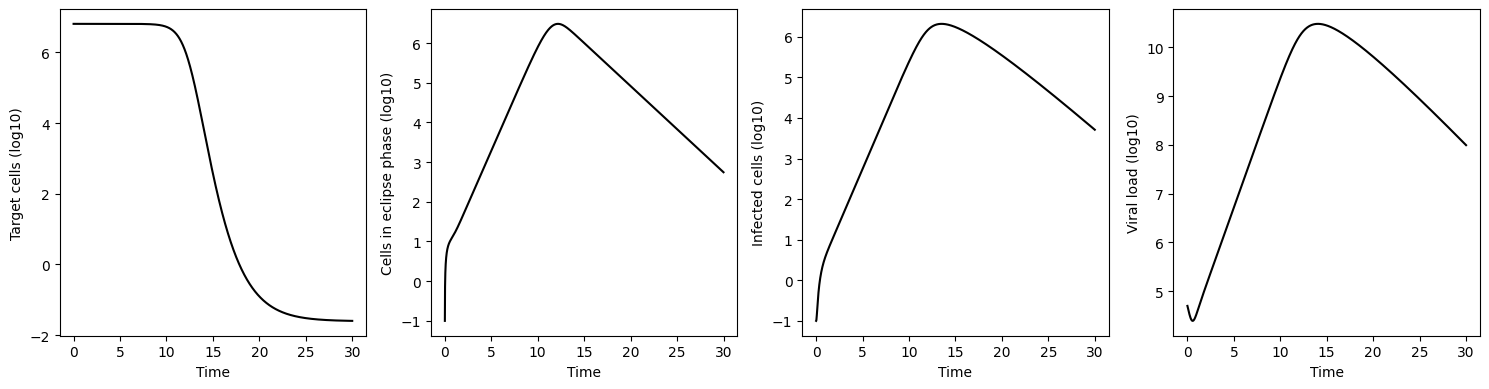

In [45]:
## プロットの準備
fig = plt.figure(figsize=(15,4))

## V(t)のプロット
ax1 = fig.add_subplot(1, 4, 1) ## 1行4列のプロットの１番目
ax1.plot(out2[0], np.log10(out2[1]), color = "black") ## pars2でのT(t)の数値解のプロット
ax1.set_xlabel("Time") ## x軸のラベル
ax1.set_ylabel("Target cells (log10)") ## y軸のラベル

## E(t)のプロット
ax2 = fig.add_subplot(1, 4, 2) ## 1行4列のプロットの2番目
ax2.plot(out2[0], np.log10(out2[2]), color = "black") ## pars2でのT(t)の数値解のプロット
ax2.set_xlabel("Time") ## x軸のラベル
ax2.set_ylabel("Cells in eclipse phase (log10)") ## y軸のラベル

## I(t)のプロット
ax3 = fig.add_subplot(1, 4, 3) ## 1行4列のプロットの3番目
ax3.plot(out2[0], np.log10(out2[3]), color = "black") ## pars2でのI(t)の数値解のプロット
ax3.set_xlabel("Time") ## x軸のラベル
ax3.set_ylabel("Infected cells (log10)") ## y軸のラベル

## V(t)のプロット
ax4 = fig.add_subplot(1, 4, 4) ## 1行4列のプロットの4番目
ax4.plot(out2[0], np.log10(out2[4]), color = "black") ## pars2でのV(t)の数値解のプロット
ax4.set_xlabel("Time") ## x軸のラベル
ax4.set_ylabel("Viral load (log10)") ## y軸のラベル

fig.tight_layout()
fig.show()

### アーロン分布による近似

$n_E=3$の場合、$k=1,2,…,n_E$に対して、アーラン分布にしたがう分布遅れをもつ微分方程式(4.6)は式(4.7)

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d E_1(t)}{dt} = \beta T(t) V(t) - \frac{n_E}{\tau_E}E_1(t) \\
\frac{d E_2(t)}{dt} = \frac{n_E}{\tau_E} \left( E_1(t) - E_2(t) \right) \\
\frac{d E_3(t)}{dt} = \frac{n_E}{\tau_E} \left( E_2(t) - E_3(t) \right) \\
\frac{d I(t)}{dt} = \frac{n_E}{\tau_E} E_3(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

の常微分方程式で書き下すことができる。

ここで$τ_E=0.98$である。

In [46]:
## 計算する時刻の設定
Tmin = 0.0
Tmax = 30.0
step_size = 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars3 = np.array([1.0*np.power(10.0, -10.0), #beta
                  0.5,                        #delta
                  3.0*np.power(10.0, 4.0),    #p
                  2.0,                        #c
                  3.0,                        #n_E
                  0.98,                       #tau_E
                  6.46*np.power(10.0, 6.0),   #T(0)
                  np.power(10.0, -1.0),       #E_1(0)
                  np.power(10.0, -1.0),       #E_2(0)
                  np.power(10.0, -1.0),       #E_3(0)
                  np.power(10.0, -1.0),       #I(0)
                  5.0*np.power(10.0, 4.0)])   #V(0)

In [47]:
def ode_derives(var, t, beta, delta, p, c, n_E, tau_E):
    
    TC, EC1, EC2, EC3, IC, VL = var
    
    dTdt = - beta * TC * VL
    dE1dt = beta * TC * VL - (n_E/tau_E) * EC1
    dE2dt = (n_E/tau_E) * (EC1 - EC2)
    dE3dt = (n_E/tau_E) * (EC2 - EC3)
    dIdt = (n_E/tau_E) * EC3 - delta * IC
    dVdt = p * IC - c * VL
    return [dTdt, dE1dt, dE2dt, dE3dt, dIdt, dVdt]


def ODEs(parms):
    beta = parms[0]
    delta = parms[1]
    p = parms[2]
    c = parms[3]
    n_E = parms[4]
    tau_E = parms[5]

    ## 計算のタイムステップ
    t_list = np.arange(Tmin, Tmax + step_size, step_size)
    ## 初期値 T(0), E(0), I(0), V(0)
    var_init = [parms[6], parms[7], parms[8], parms[9], parms[10], parms[11]]
    ## 微分方程式の計算
    var_list = odeint(ode_derives, var_init, t_list, args = (beta, delta, p, c, n_E, tau_E))

    return np.vstack([t_list, var_list.T])

In [48]:
out3 = ODEs(pars3)

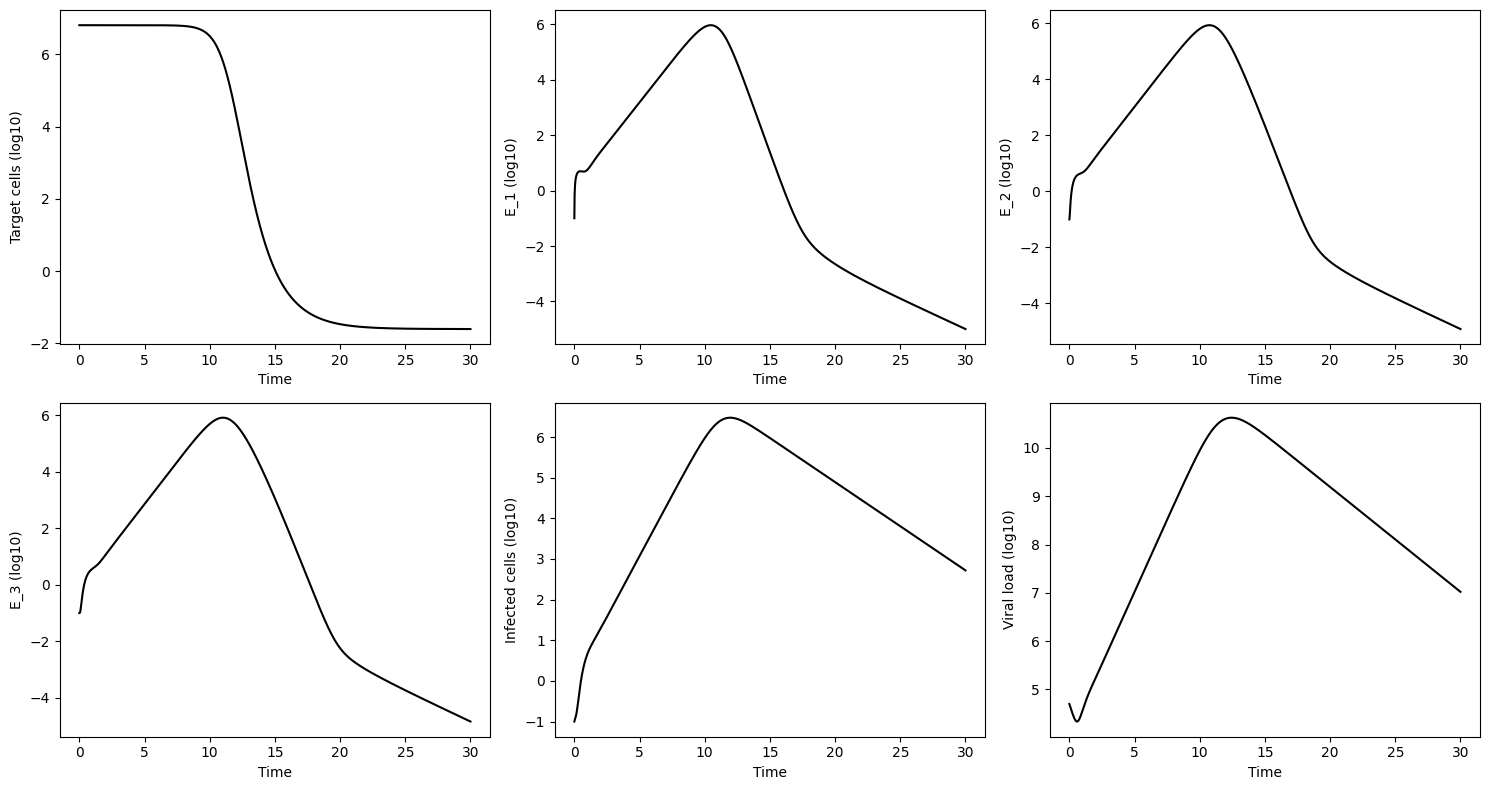

In [49]:
## プロットの準備
fig = plt.figure(figsize=(15,8))

for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(out3[0], np.log10(out3[i + 1]), color = "black")
    ax.set_xlabel("Time")
    ax.set_ylabel(["Target cells (log10)", "E_1 (log10)", "E_2 (log10)", "E_3 (log10)", \
                   "Infected cells (log10)", "Viral load (log10)"][i])

fig.tight_layout()
fig.show()

### SHIVシングルサイクル感染実験の定量的データ解析

In [50]:
## 計算する時刻の設定
Tmin = 0.0
Tmax = 3.0
step_size = 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars4 = np.array([1.0*np.power(10.0, -10.0),  #beta
                  14.0,                       #delta
                  3.26*np.power(10.0, 4.0),   #p
                  0.039,                      #c
                  3.0,                        #n_E
                  0.98,                       #tau_E
                  0.0,                        #T(0)
                  np.power(10.0, 6.0),        #E_1(0)
                  0.0,                        #E_2(0)
                  0.0,                        #E_3(0)
                  0.0,                        #I(0)
                  1.29*np.power(10.0, 9.0)])  #V(0)

In [51]:
out4 = []
for i in range(2):
    pars4[1] = [1.57, 14.0][i]
    out4.append(ODEs(pars4))

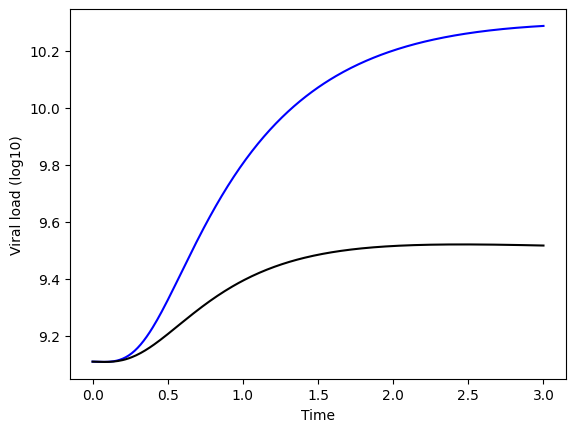

In [52]:
## プロット（図4.6C）

for i in range(2):
    plt.plot(out4[i][0], np.log10(out4[i][6]), color = ["blue", "black"][i])
    
plt.xlabel("Time")
plt.ylabel("Viral load (log10)")

fig.tight_layout()
fig.show()